<a href="https://colab.research.google.com/github/jhlee508/pytorch-advanced/blob/master/chapter5_gan_generation_DCGAN%2BSAGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Git Clone

In [ ]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 552 (delta 36), reused 47 (delta 18), pack-reused 479
Receiving objects: 100% (552/552), 17.83 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (295/295), done.


In [ ]:
%cd pytorch_advanced/

/content/pytorch_advanced


In [ ]:
!ls

1_image_classification	 7_nlp_sentiment_transformer
2_objectdetection	 8_nlp_sentiment_bert
3_semantic_segmentation  9_video_classification_eco
4_pose_estimation	 etc
5_gan_generation	 LICENSE
6_gan_anomaly_detection  README.md


In [ ]:
%cd 5_gan_generation/

/content/pytorch_advanced/5_gan_generation


In [ ]:
!pwd

/content/pytorch_advanced/5_gan_generation


In [ ]:
!ls

5-1_2_DCGAN.ipynb  5-4_SAGAN.ipynb  make_folders_and_data_downloads.ipynb


### Make Folders and Data Downloads

In [ ]:
import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

In [ ]:
# data 폴더가 없으면 작성한다
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [ ]:
# AWS의 AMI에서 sklern의 version이 0.20보다 낮은 경우에는 버전을 업데이트합니다
# pip install -U scikit-learn

import sklearn
print(sklearn.__version__)

1.0.2


In [ ]:
# MNIST의 필기체 숫자 화상을 다운로드하여 읽습니다(2분 정도 걸립니다)
from sklearn.datasets import fetch_openml

# data_home으로 저장 위치를 지정합니다
mnist = fetch_openml('mnist_784', version=1, data_home="./data/", as_frame=False)  

In [ ]:
# 데이터 꺼내기
X = mnist.data
y = mnist.target

이 화상 데이터의 라벨은 5입니다


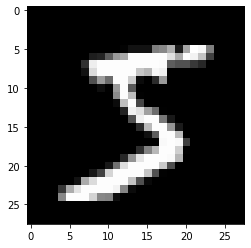

In [ ]:
# MNIST의 데이터 첫 번째를 시각화
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 화상 데이터의 라벨은 {}입니다".format(y[0]))

In [ ]:
# "data" 폴더의 아래에 "img_78" 폴더를 작성한다
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [ ]:
# MNIST에서 숫자 7, 8의 화상만 "img_78" 폴더에 화상으로 저장한다
count7 = 0
count8 = 0
max_num = 200  # 화상은 200장씩 작성한다

for i in range(len(X)):
    
    # 화상7 작성
    if (y[i] is "7") and (count7 < max_num):
        file_path="./data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count7 += 1 
    
    # 화상8 작성
    if (y[i] is "8") and (count8 < max_num):
        file_path="./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count8 += 1 

# Chapter5. GAN 이미지 생성 (DCGAN, Self-Attention GAN)

## DCGAN

In [ ]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [ ]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### Generator 구현

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        # 주의: 흑백 화상이므로 출력 채널은 1이다
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

In [ ]:
# 난수 입력
input_z = torch.randn(1, 20)
input_z.shape

torch.Size([1, 20])

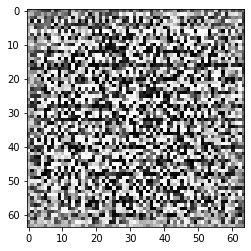

In [ ]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기를 (1, 20, 1, 1)으로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상을 출력
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

### Discriminator 구현

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super().__init__()

        # 주의: 흑백 화상이므로 입력 채널은 1이다
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

In [ ]:
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1, 20, 1, 1)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out = D(fake_images)
print(d_out)

# 출력 d_out에 Sigmoid를 곱해 0 ~ 1 사이의 값으로 변환
print(nn.Sigmoid()(d_out))

tensor([[[[0.0179]]]], grad_fn=<MkldnnConvolutionBackward0>)
tensor([[[[0.5045]]]], grad_fn=<SigmoidBackward0>)


### DCGAN의 손실 함수

In [ ]:
# D의 오차함수의 이미지 구현
# maximize log(D(x)) + log(1 - D(G(z)))


# ※ x가 정의되지 않았으므로, 에러 발생
#---------------


# 정답 라벨 작성
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

# 가짜 라벨 작성
label_fake = torch.full((mini_batch_size,), 0)

# 오차함수 정의
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 진짜 화상을 판정
d_out_real = D(x)

# 가짜 화상을 생성해 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차를 계산
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake

NameError: ignored

In [ ]:
# G의 오차함수의 이미지 구현
# maximize log(D(G(z)))


# ※ x가 정의되지 않았으므로, 에러가 됩니다
#---------------


# 가짜 화상을 생성해 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차를 계산
g_loss = criterion(d_out_fake.view(-1), label_real)

RuntimeError: ignored

### Dataset & DataLoader 작성

In [ ]:
def make_datapath_list():
    """
    학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. 
    """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [ ]:
class ImageTransform():
    """
    화상의 전처리 클래스
    """

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [ ]:
class GAN_Img_Dataset(data.Dataset):
    """
    화상의 Dataset 클래스. 
    PyTorch의 Dataset 클래스를 상속.
    """

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭][흑백]

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed

In [ ]:
# DataLoader 동작 확인

# 파일 리스트를 작성
train_img_list = make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 64, 64])


### 학습

In [ ]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2d & ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02) 
        nn.init.constant_(m.bias.data, 0) 
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")

네트워크 초기화 완료


In [ ]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치:", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 진짜 화상을 판정
            d_out_real = D(imges)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차를 계산
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D

In [ ]:
# 학습 및 검증을 실행한다
# 6분 정도 걸립니다
num_epochs = 200
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

사용 장치: cuda:0
-------------
Epoch 0/200
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.0841 ||Epoch_G_Loss:0.1587
timer:  0.6426 sec.
-------------
Epoch 1/200
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.0441 ||Epoch_G_Loss:0.2888
timer:  0.4901 sec.
-------------
Epoch 2/200
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.0027 ||Epoch_G_Loss:0.5279
timer:  0.4912 sec.
-------------
Epoch 3/200
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.1253 ||Epoch_G_Loss:0.1860
timer:  0.4907 sec.
-------------
Epoch 4/200
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.0031 ||Epoch_G_Loss:0.5161
timer:  0.4927 sec.
-------------
Epoch 5/200
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.8110 ||Epoch_G_Loss:0.8075
timer:  0.4992 sec.
-------------
Epoch 6/200
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.0139 ||Epoch_G_Loss:0.3029
timer:  0.4860 sec.
-------------
Epoch 7/200
-------------
(

### 추론

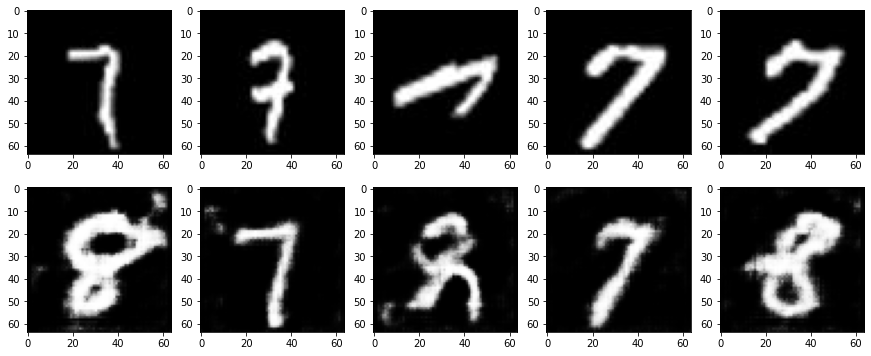

In [ ]:
# 생성 화상과 훈련 데이터를 시각화한다
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지, 몇 번을 재실행하고 있습니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')